# Final_Project_Aditya_Mahaddalkar

### Name: Aditya Mahaddalkar
### USC Id: 2042907087
### Github Username: AdityaMahaddalkar

# Identification of Frost in Martian HiRISE Images

* In this problem, we are trying to build a classifier that distinguishes images of Martian terrain with frost
* This dataset was created to study Mars’ seasonal frost cycle and its role in the planet’s climate and surface evolution over the past 2 billion years.
* The data helps in identifying low-latitude frosted microclimates and their impact on climate.

In [1]:
import os
from PIL import Image
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import shutil
from tqdm import tqdm
import pandas as pd

import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback, RichProgressBar

from torchmetrics.classification import Accuracy

from torchvision import models

import warnings
warnings.filterwarnings('ignore')

torch.set_float32_matmul_precision('medium')

torch.cuda.empty_cache()

In [2]:
all_metrics_df = {
    'name': [],
    'type': [],
    'precision': [],
    'recall': [],
    'f1': []
}

In [3]:
ALL_DATA_FOLDERS = list(os.walk('data'))[0][1]

def collect_images_from_folders(folder_names_file, src_root, dest_root):
    # Read folder names from the text file
    with open(folder_names_file, 'r') as file:
        folder_names = file.read().splitlines()

    # Create destination folders if they don't exist
    dest_frost = os.path.join(dest_root, 'frost')
    dest_background = os.path.join(dest_root, 'background')
    os.makedirs(dest_frost, exist_ok=True)
    os.makedirs(dest_background, exist_ok=True)

    # Iterate through each folder
    for folder_name in tqdm(folder_names):
        
        full_folder_names = filter(lambda folder: folder_name in folder, ALL_DATA_FOLDERS)
        
        for full_folder_name in full_folder_names:
        
            folder_path = os.path.join(src_root, full_folder_name)

            # Check if 'frost' folder exists
            frost_folder = os.path.join(folder_path, 'tiles', 'frost')
            if os.path.exists(frost_folder):
                # Copy all files from 'frost' folder to the destination 'frost' folder
                for file_name in os.listdir(frost_folder):
                    src_path = os.path.join(frost_folder, file_name)
                    dest_path = os.path.join(dest_frost, f"{folder_name}_{file_name}")
                    shutil.copy(src_path, dest_path)

            # Check if 'background' folder exists
            background_folder = os.path.join(folder_path, 'tiles', 'background')
            if os.path.exists(background_folder):
                # Copy all files from 'background' folder to the destination 'background' folder
                for file_name in os.listdir(background_folder):
                    src_path = os.path.join(background_folder, file_name)
                    dest_path = os.path.join(dest_background, f"{folder_name}_{file_name}")
                    shutil.copy(src_path, dest_path)

In [4]:
folder_names_file = 'train_source_images.txt'  # Replace with your actual file
src_root = 'data'  # Replace with your actual source root
dest_root = 'train'  # Replace with your actual destination root

if not os.path.isdir(dest_root):
    collect_images_from_folders(folder_names_file, src_root, dest_root)

In [5]:
folder_names_file = 'val_source_images.txt'  # Replace with your actual file
src_root = 'data'  # Replace with your actual source root
dest_root = 'val'  # Replace with your actual destination root

if not os.path.isdir(dest_root):
    collect_images_from_folders(folder_names_file, src_root, dest_root)

In [6]:
folder_names_file = 'test_source_images.txt'  # Replace with your actual file
src_root = 'data'  # Replace with your actual source root
dest_root = 'test'  # Replace with your actual destination root

if not os.path.isdir(dest_root):
    collect_images_from_folders(folder_names_file, src_root, dest_root)

## CNN + MLP

In [7]:
class MetricTracker(Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
            
    def on_validation_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss'])
        
        if 'val_loss' in trainer.callback_metrics:
            self.val_losses.append(trainer.callback_metrics['val_loss'])

* Note: L2 Regulariztion in PyTorch is implemented as weight decay in optimizer, there is no l2_regularization parameter in nn.Dense layers. Source: https://medium.com/analytics-vidhya/understanding-regularization-with-pytorch-26a838d94058#:~:text=The%20weight_decay%20parameter%20applies%20L2%20regularization%20while%20initialising%20optimizer.%20This%20adds%20regularization%20term%20to%20the%20loss%20function%2C%20with%20the%20effect%20of%20shrinking%20the%20parameter%20estimates%2C%20making%20the%20model%20simpler%20and%20less%20likely%20to%20overfit

In [8]:
class ThreeLayerCNNLightning(LightningModule):
    def __init__(self, learning_rate=1e-3):
        super(ThreeLayerCNNLightning, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Flatten(),
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2),
            nn.Softmax(dim=1)
        )

        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        self.log_dict({'train_loss': loss}, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        self.log_dict({'val_loss': loss}, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        return optimizer

In [9]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ToTensor(),
])

normal_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

In [10]:
train_folder = 'train'
test_folder = 'test'
val_folder = 'val'

train_dataset = ImageFolder(root=train_folder, transform=transform)
test_dataset = ImageFolder(root=test_folder, transform=normal_transform)
val_dataset = ImageFolder(root=test_folder, transform=normal_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)

In [11]:
def report_metrics(model, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, all_metrics_df=all_metrics_df):
    
    for name, loader in [('train', train_loader), ('val', val_loader), ('test', test_loader)]:
        
        all_predictions, all_labels = [], []
        
        model.eval()
        with torch.no_grad():
            for images, labels in loader:
                outputs = model(images.to('cuda'))
                _, predictions = torch.max(outputs, 1)
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate precision, recall, and F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

        print(f"Model = {str(model).split('(')[0]} Data = {name} Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        
        all_metrics_df['name'].append(str(model).split('(')[0])
        all_metrics_df['type'].append(name)
        all_metrics_df['precision'].append(precision)
        all_metrics_df['recall'].append(recall)
        all_metrics_df['f1'].append(f1)

In [12]:
model = ThreeLayerCNNLightning(learning_rate=1e-3)

early_stop_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')

checkpoint_callback = ModelCheckpoint(
    dirpath='models/base',
    filename='best-model',
    monitor='val_loss',
    mode='min',
    verbose=True,
    save_top_k=1,  # Save only the best model
)

custom_callback = MetricTracker()

progress_bar = RichProgressBar(leave=True)

min_epochs = 20
max_epochs = 50

In [13]:
trainer = Trainer(
    min_epochs=min_epochs,
    max_epochs=max_epochs,
    callbacks=[early_stop_callback, checkpoint_callback, custom_callback, progress_bar],
    accelerator="auto",
    precision='16'
)
trainer.fit(model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ Sequential │ 12.9 M │
└───┴───────┴────────────┴────────┘

Trainable params: 12.9 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 12.9 M                                                                                               
Total estimated model params size (MB): 51

Output()

Epoch 0, global step 221: 'val_loss' reached 0.67340 (best 0.67340), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\base\\best-model-v3.ckpt' as top 1


Output()

Epoch 1, global step 442: 'val_loss' was not in top 1


Output()

Epoch 2, global step 663: 'val_loss' was not in top 1


Output()

Epoch 3, global step 884: 'val_loss' was not in top 1


Output()

Trainer was signaled to stop but the required `min_epochs=20` or `min_steps=None` has not been met. Training will continue...
Epoch 4, global step 1105: 'val_loss' was not in top 1


Output()

Epoch 5, global step 1326: 'val_loss' was not in top 1


Output()

Epoch 6, global step 1547: 'val_loss' reached 0.57101 (best 0.57101), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\base\\best-model-v3.ckpt' as top 1


Output()

Epoch 7, global step 1768: 'val_loss' was not in top 1


Output()

Epoch 8, global step 1989: 'val_loss' was not in top 1


Output()

Epoch 9, global step 2210: 'val_loss' was not in top 1


Output()

Epoch 10, global step 2431: 'val_loss' reached 0.56175 (best 0.56175), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\base\\best-model-v3.ckpt' as top 1


Output()

Epoch 11, global step 2652: 'val_loss' reached 0.54122 (best 0.54122), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\base\\best-model-v3.ckpt' as top 1


Output()

Epoch 12, global step 2873: 'val_loss' was not in top 1


Output()

Epoch 13, global step 3094: 'val_loss' was not in top 1


Output()

Epoch 14, global step 3315: 'val_loss' was not in top 1


Output()

Epoch 15, global step 3536: 'val_loss' was not in top 1


Output()

Epoch 16, global step 3757: 'val_loss' was not in top 1


Output()

Epoch 17, global step 3978: 'val_loss' was not in top 1


Output()

Epoch 18, global step 4199: 'val_loss' was not in top 1


Output()

Epoch 19, global step 4420: 'val_loss' was not in top 1


In [14]:
train_losses = [x.cpu().item() for x in custom_callback.train_losses]
val_losses = [x.cpu().item() for x in custom_callback.val_losses[:len(custom_callback.train_losses)]]

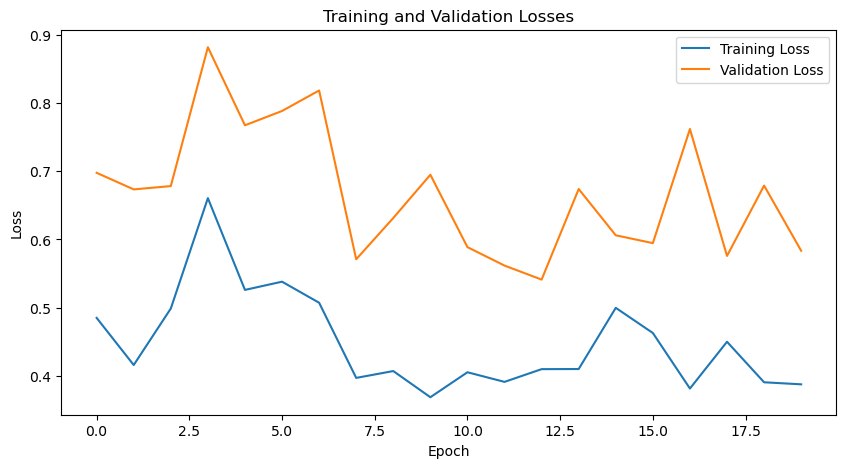

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [16]:
model = ThreeLayerCNNLightning.load_from_checkpoint('models/base/best-model.ckpt')

In [17]:
report_metrics(model)

Model = ThreeLayerCNNLightning Data = train Precision: 0.7681, Recall: 0.9640, F1 Score: 0.8550
Model = ThreeLayerCNNLightning Data = val Precision: 0.7873, Recall: 0.9364, F1 Score: 0.8554
Model = ThreeLayerCNNLightning Data = test Precision: 0.7873, Recall: 0.9364, F1 Score: 0.8554


## EfficientNetB0

In [18]:
class EfficientNetB0LightningFrozen(LightningModule):
    def __init__(self, num_classes=2, freeze_layers=True, learning_rate=1e-3):
        super(EfficientNetB0LightningFrozen, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        
        for name, param in self.model.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False
        
        self.fc = nn.Sequential(
            nn.Linear(1000, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        
    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log_dict({'train_loss': loss}, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log_dict({'val_loss': loss}, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        return optimizer

In [19]:
efficient_net_model = EfficientNetB0LightningFrozen()

early_stop_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')

checkpoint_callback = ModelCheckpoint(
    dirpath='models/efficientnet',
    filename='best-model',
    monitor='val_loss',
    mode='min',
    verbose=True,
    save_top_k=1,  # Save only the best model
)

custom_callback = MetricTracker()

progress_bar = RichProgressBar(leave=True)

min_epochs = 10
max_epochs = 50

In [20]:
trainer = Trainer(
    min_epochs=min_epochs,
    max_epochs=max_epochs,
    callbacks=[early_stop_callback, checkpoint_callback, custom_callback, progress_bar],
    accelerator="auto",
    precision='16'
)
trainer.fit(efficient_net_model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model     │ EfficientNet     │  5.3 M │
│ 1 │ fc        │ Sequential       │  128 K │
│ 2 │ criterion │ CrossEntropyLoss │      0 │
└───┴───────────┴──────────────────┴────────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 4.0 M                                                                                        
Total params: 5.4 M                                                                                                
Total estimated model params size (MB): 21

Output()

Epoch 0, global step 221: 'val_loss' reached 0.47471 (best 0.47471), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\efficientnet\\best-model-v2.ckpt' as top 1


Output()

Epoch 1, global step 442: 'val_loss' was not in top 1


Output()

Epoch 2, global step 663: 'val_loss' was not in top 1


Output()

Epoch 3, global step 884: 'val_loss' reached 0.47298 (best 0.47298), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\efficientnet\\best-model-v2.ckpt' as top 1


Output()

Epoch 4, global step 1105: 'val_loss' was not in top 1


Output()

Epoch 5, global step 1326: 'val_loss' was not in top 1


Output()

Epoch 6, global step 1547: 'val_loss' reached 0.46358 (best 0.46358), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\efficientnet\\best-model-v2.ckpt' as top 1


Output()

Epoch 7, global step 1768: 'val_loss' reached 0.44534 (best 0.44534), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\efficientnet\\best-model-v2.ckpt' as top 1


Output()

Epoch 8, global step 1989: 'val_loss' was not in top 1


Output()

Epoch 9, global step 2210: 'val_loss' was not in top 1


Output()

Epoch 10, global step 2431: 'val_loss' was not in top 1


In [21]:
train_losses = [x.cpu().item() for x in custom_callback.train_losses]
val_losses = [x.cpu().item() for x in custom_callback.val_losses[:len(custom_callback.train_losses)]]

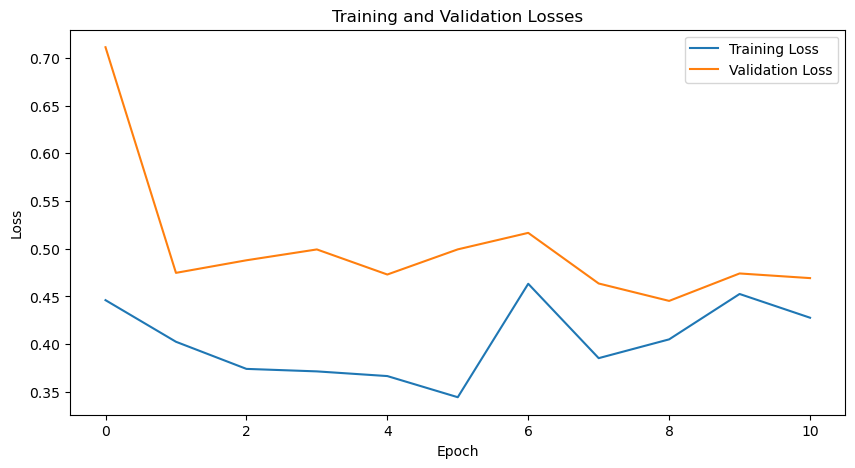

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [23]:
efficient_net_model = EfficientNetB0LightningFrozen.load_from_checkpoint('models/efficientnet/best-model.ckpt')

In [24]:
report_metrics(efficient_net_model)

Model = EfficientNetB0LightningFrozen Data = train Precision: 0.9701, Recall: 0.9485, F1 Score: 0.9592
Model = EfficientNetB0LightningFrozen Data = val Precision: 0.8948, Recall: 0.9356, F1 Score: 0.9147
Model = EfficientNetB0LightningFrozen Data = test Precision: 0.8948, Recall: 0.9356, F1 Score: 0.9147


## ResNet50

In [25]:
class ResNet50LightningFrozen(LightningModule):
    def __init__(self, num_classes=2, freeze_layers=True, learning_rate=1e-3):
        super(ResNet50LightningFrozen, self).__init__()
        self.model = models.resnet50(pretrained=True)
        
        for name, param in self.model.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False
        
        self.fc = nn.Sequential(
            nn.Linear(1000, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        
    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log_dict({'train_loss': loss}, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log_dict({'val_loss': loss}, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        return optimizer

In [26]:
resnet_model = ResNet50LightningFrozen()

early_stop_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')

checkpoint_callback = ModelCheckpoint(
    dirpath='models/resnet',
    filename='best-model',
    monitor='val_loss',
    mode='min',
    verbose=True,
    save_top_k=1,  # Save only the best model
)

custom_callback = MetricTracker()

progress_bar = RichProgressBar(leave=True)

min_epochs = 10
max_epochs = 50

In [27]:
trainer = Trainer(
    min_epochs=min_epochs,
    max_epochs=max_epochs,
    callbacks=[early_stop_callback, checkpoint_callback, custom_callback, progress_bar],
    accelerator="auto",
    precision='16'
)
trainer.fit(resnet_model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model     │ ResNet           │ 25.6 M │
│ 1 │ fc        │ Sequential       │  128 K │
│ 2 │ criterion │ CrossEntropyLoss │      0 │
└───┴───────────┴──────────────────┴────────┘

Trainable params: 2.2 M                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 25.7 M                                                                                               
Total estimated model params size (MB): 102

Output()

Epoch 0, global step 221: 'val_loss' reached 0.79106 (best 0.79106), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\resnet\\best-model-v1.ckpt' as top 1


Output()

Epoch 1, global step 442: 'val_loss' reached 0.50786 (best 0.50786), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\resnet\\best-model-v1.ckpt' as top 1


Output()

Epoch 2, global step 663: 'val_loss' was not in top 1


Output()

Epoch 3, global step 884: 'val_loss' reached 0.49984 (best 0.49984), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\resnet\\best-model-v1.ckpt' as top 1


Output()

Epoch 4, global step 1105: 'val_loss' reached 0.48022 (best 0.48022), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\resnet\\best-model-v1.ckpt' as top 1


Output()

Epoch 5, global step 1326: 'val_loss' was not in top 1


Output()

Epoch 6, global step 1547: 'val_loss' was not in top 1


Output()

Epoch 7, global step 1768: 'val_loss' reached 0.46563 (best 0.46563), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\resnet\\best-model-v1.ckpt' as top 1


Output()

Epoch 8, global step 1989: 'val_loss' was not in top 1


Output()

Epoch 9, global step 2210: 'val_loss' was not in top 1


Output()

Epoch 10, global step 2431: 'val_loss' was not in top 1


In [28]:
train_losses = [x.cpu().item() for x in custom_callback.train_losses]
val_losses = [x.cpu().item() for x in custom_callback.val_losses[:len(custom_callback.train_losses)]]

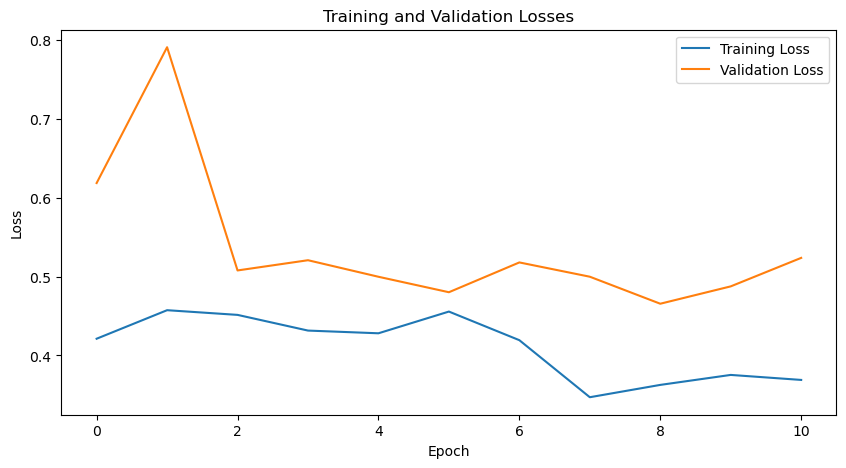

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [30]:
resnet_model = ResNet50LightningFrozen.load_from_checkpoint('models/resnet/best-model.ckpt')

In [31]:
report_metrics(resnet_model)

Model = ResNet50LightningFrozen Data = train Precision: 0.9517, Recall: 0.9630, F1 Score: 0.9573
Model = ResNet50LightningFrozen Data = val Precision: 0.8974, Recall: 0.8817, F1 Score: 0.8895
Model = ResNet50LightningFrozen Data = test Precision: 0.8974, Recall: 0.8817, F1 Score: 0.8895


## VGG

In [32]:
class VGG16LightningFrozen(LightningModule):
    def __init__(self, num_classes=2, freeze_layers=True, learning_rate=1e-3):
        super(VGG16LightningFrozen, self).__init__()
        self.model = models.vgg16(pretrained=True)
        
        for name, param in self.model.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False
        
        self.fc = nn.Sequential(
            nn.Linear(1000, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        
    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log_dict({'train_loss': loss}, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log_dict({'val_loss': loss}, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        return optimizer

In [33]:
vgg16_model = VGG16LightningFrozen()

early_stop_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')

checkpoint_callback = ModelCheckpoint(
    dirpath='models/vgg',
    filename='best-model',
    monitor='val_loss',
    mode='min',
    verbose=True,
    save_top_k=1,  # Save only the best model
)

custom_callback = MetricTracker()

progress_bar = RichProgressBar(leave=True)

min_epochs = 10
max_epochs = 50

In [34]:
trainer = Trainer(
    min_epochs=min_epochs,
    max_epochs=max_epochs,
    callbacks=[early_stop_callback, checkpoint_callback, custom_callback, progress_bar],
    accelerator="auto",
    precision='16'
)
trainer.fit(vgg16_model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model     │ VGG              │  138 M │
│ 1 │ fc        │ Sequential       │  128 K │
│ 2 │ criterion │ CrossEntropyLoss │      0 │
└───┴───────────┴──────────────────┴────────┘

Trainable params: 123 M                                                                                            
Non-trainable params: 14.7 M                                                                                       
Total params: 138 M                                                                                                
Total estimated model params size (MB): 553

Output()

Epoch 0, global step 221: 'val_loss' reached 0.55458 (best 0.55458), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\vgg\\best-model-v1.ckpt' as top 1


Output()

Epoch 1, global step 442: 'val_loss' was not in top 1


Output()

Epoch 2, global step 663: 'val_loss' reached 0.55163 (best 0.55163), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\vgg\\best-model-v1.ckpt' as top 1


Output()

Epoch 3, global step 884: 'val_loss' reached 0.54329 (best 0.54329), saving model to 'C:\\Aditya\\Work\\USC\\ml\\final-project-aditya-mahaddalkar\\models\\vgg\\best-model-v1.ckpt' as top 1


Output()

Epoch 4, global step 1105: 'val_loss' was not in top 1


Output()

Epoch 5, global step 1326: 'val_loss' was not in top 1


Output()

Epoch 6, global step 1547: 'val_loss' was not in top 1


Output()

Trainer was signaled to stop but the required `min_epochs=10` or `min_steps=None` has not been met. Training will continue...
Epoch 7, global step 1768: 'val_loss' was not in top 1


Output()

Epoch 8, global step 1989: 'val_loss' was not in top 1


Output()

Epoch 9, global step 2210: 'val_loss' was not in top 1


In [35]:
train_losses = [x.cpu().item() for x in custom_callback.train_losses]
val_losses = [x.cpu().item() for x in custom_callback.val_losses[:len(custom_callback.train_losses)]]

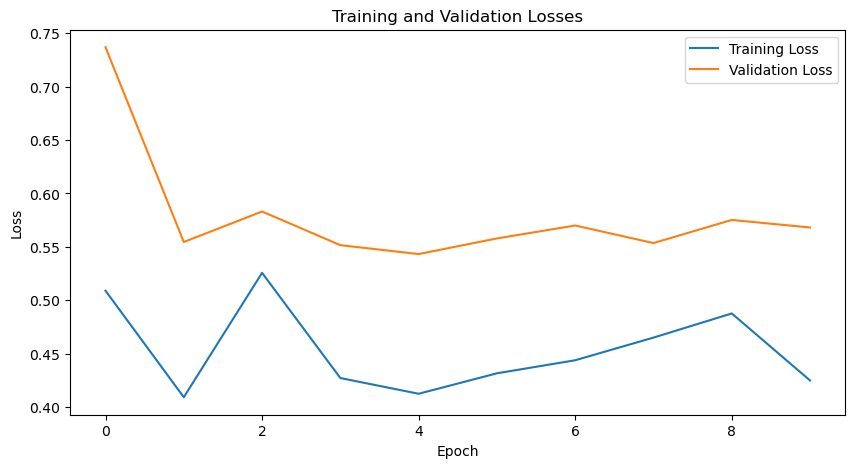

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [37]:
vgg16_model = VGG16LightningFrozen.load_from_checkpoint('models/vgg/best-model.ckpt')

In [38]:
report_metrics(vgg16_model)

Model = VGG16LightningFrozen Data = train Precision: 0.8887, Recall: 0.9077, F1 Score: 0.8981
Model = VGG16LightningFrozen Data = val Precision: 0.8081, Recall: 0.9299, F1 Score: 0.8647
Model = VGG16LightningFrozen Data = test Precision: 0.8081, Recall: 0.9299, F1 Score: 0.8647


## Comparison

In [39]:
all_metrics_df = pd.DataFrame(all_metrics_df)
all_metrics_df.sort_values(by='f1', ascending=False)

,name,type,precision,recall,f1
3,EfficientNetB0LightningFrozen,train,0.970055,0.948514,0.959163
6,ResNet50LightningFrozen,train,0.951700,0.962991,0.957312
4,EfficientNetB0LightningFrozen,val,0.894815,0.935573,0.914740
5,EfficientNetB0LightningFrozen,test,0.894815,0.935573,0.914740
9,VGG16LightningFrozen,train,0.888735,0.907696,0.898115
7,ResNet50LightningFrozen,val,0.897409,0.881711,0.889491
8,ResNet50LightningFrozen,test,0.897409,0.881711,0.889491
10,VGG16LightningFrozen,val,0.808098,0.929858,0.864713
11,VGG16LightningFrozen,test,0.808098,0.929858,0.864713
1,ThreeLayerCNNLightning,val,0.787274,0.936439,0.855403


* From the results we can deduce that transfer learning performs way better than custom CNN + MLP model
* This is because the base models used in transfer learning are designed and tested using advance methodologies and fine-tuned on bigger dataset
* This helps the models retain valuable information that can be used to train the final layer on custom data.
* This helps in explanation of high f1 scores for all transfer learning models
* Out of all pre-trained models, EfficientNetB0 is the current state of the art model which explains it's highest f1 score.